# SET-UP

In this section, the relevant libraries are imported and the dataset is set up.

In [1]:
# imports

import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

In [2]:
# download if zip files not already downloaded
if not os.path.exists('davis.zip'):
    !gdown '1ktIvlhO7cz_dL7oxeoVgZOjKlT0fSw2G'
else:
    print('davis.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('davis'):
    !unzip -qq davis.zip
    !rm davis.zip
else:
    print('davis folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1ktIvlhO7cz_dL7oxeoVgZOjKlT0fSw2G
From (redirected): https://drive.google.com/uc?id=1ktIvlhO7cz_dL7oxeoVgZOjKlT0fSw2G&confirm=t&uuid=aee8e06e-0bd3-4599-9f2f-cabf733eecf4
To: /content/davis.zip
100% 289M/289M [00:06<00:00, 43.3MB/s]


In [3]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
from torch.utils.data import random_split, DataLoader
from seq_dataset import SeqDataset

b=4

dataset = SeqDataset(root_dir='frame_data', transform=None)

# picking out the sizes
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# apply transformations
train_dataset.dataset.transform = train_transform  # assign training transform
val_dataset.dataset.transform = valid_transform  # assign validation transform
test_dataset.dataset.transform = test_transform  # assign test transform

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=b, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=b, shuffle=False)

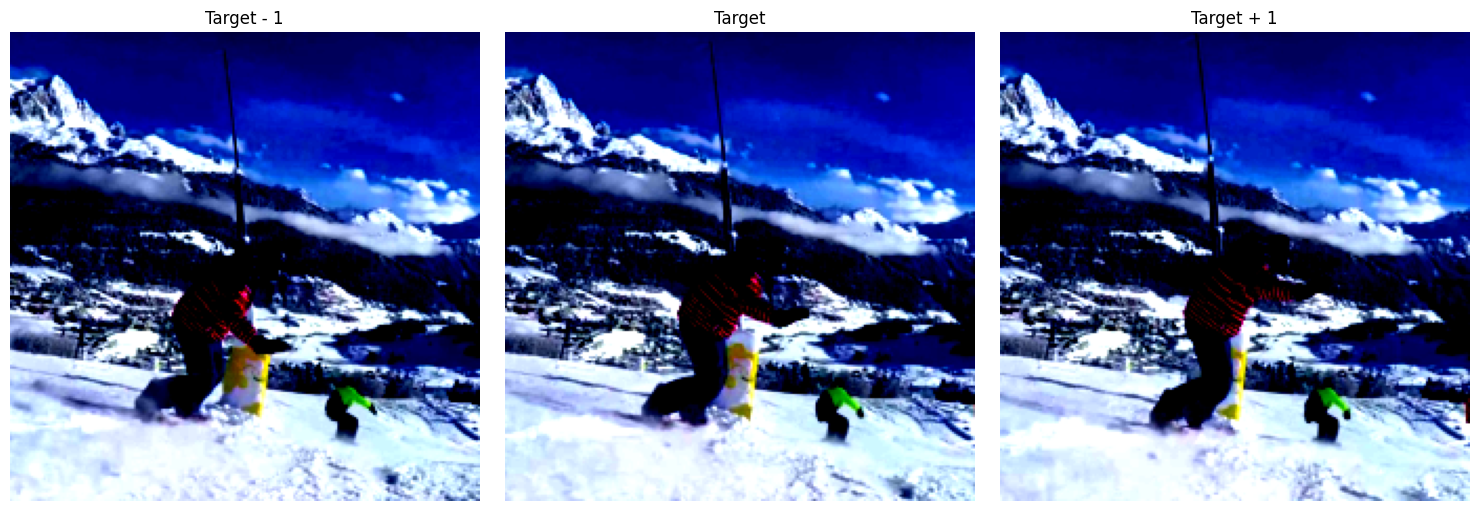

In [26]:
tgt, [s1, s2] = train_dataset[10]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

# Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def pose_vec2mat(vec):
    t = vec[:, :3].unsqueeze(-1)
    angle = vec[:, 3:]
    angle_norm = torch.norm(angle, dim=1, keepdim=True)
    axis = angle / (angle_norm + 1e-8)
    angle = angle_norm.unsqueeze(-1)

    K = torch.tensor([
        [0, -1, 0],
        [1,  0, 0],
        [0,  0, 0]
    ], dtype=torch.float32, device=vec.device)

    cross = torch.zeros(vec.shape[0], 3, 3).to(vec.device)
    cross[:, 0, 1] = -axis[:, 2]
    cross[:, 0, 2] = axis[:, 1]
    cross[:, 1, 0] = axis[:, 2]
    cross[:, 1, 2] = -axis[:, 0]
    cross[:, 2, 0] = -axis[:, 1]
    cross[:, 2, 1] = axis[:, 0]

    R = torch.eye(3, device=vec.device).unsqueeze(0) + \
        torch.sin(angle) * cross + \
        (1 - torch.cos(angle)) * torch.bmm(cross, cross)

    T = torch.cat([R, t], dim=-1)
    last_row = torch.tensor([0, 0, 0, 1], device=vec.device).view(1, 1, 4).repeat(vec.shape[0], 1, 1)
    return torch.cat([T, last_row], dim=1)


def project_3d(depth, intrinsics, pose):
    b, _, h, w = depth.shape
    grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h), indexing='xy')
    ones = torch.ones_like(grid_x)
    pixels = torch.stack([grid_x, grid_y, ones], dim=0).float().to(depth.device)
    pixels = pixels.view(3, -1).unsqueeze(0).repeat(b, 1, 1)

    cam_points = torch.inverse(intrinsics).bmm(pixels) * depth.view(b, 1, -1)
    cam_points = torch.cat([cam_points, torch.ones_like(cam_points[:, :1])], dim=1)
    proj = intrinsics.bmm(pose[:, :3, :])
    coords = proj.bmm(cam_points)

    x = coords[:, 0] / (coords[:, 2] + 1e-7)
    y = coords[:, 1] / (coords[:, 2] + 1e-7)

    x = 2 * (x / w - 0.5)
    y = 2 * (y / h - 0.5)

    grid = torch.stack([x, y], dim=-1).view(b, h, w, 2)
    return grid

In [8]:
def photometric_loss(tgt_img, warped_img):
    return torch.abs(tgt_img - warped_img).mean()


def edge_aware_smoothness(depth, img):
    img_gray = img.mean(1, keepdim=True)

    dx_depth = torch.abs(depth[:, :, :, :-1] - depth[:, :, :, 1:])
    dy_depth = torch.abs(depth[:, :, :-1, :] - depth[:, :, 1:, :])

    dx_img = torch.abs(img_gray[:, :, :, :-1] - img_gray[:, :, :, 1:])
    dy_img = torch.abs(img_gray[:, :, :-1, :] - img_gray[:, :, 1:, :])

    weight_x = torch.exp(-torch.abs(dx_img))
    weight_y = torch.exp(-torch.abs(dy_img))

    loss = (dx_depth * weight_x).mean() + (dy_depth * weight_y).mean()
    return loss

In [18]:
from depth_net import DepthNet
from pose_net import PoseNet

depth_net = DepthNet().to(device)
pose_net = PoseNet().to(device)

intrinsics = torch.eye(3).unsqueeze(0).repeat(b, 1, 1).to(device)

params = list(depth_net.parameters()) + list(pose_net.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)

In [19]:
for epoch in range(100):
    print(f"\nEPOCH {epoch+1} -----------------------------")
    total_loss = 0.0
    total_photo_loss = 0.0
    total_smooth_loss = 0.0
    num_batches = 0

    for tgt, [src1, src2] in train_loader:
        # move to GPU
        tgt = tgt.to(device)
        src1 = src1.to(device)

        # forward pass
        disp = depth_net(tgt)
        disp = F.interpolate(disp, size=(224, 224), mode='bilinear', align_corners=True)
        depth = 1 / (disp + 1e-6)

        pose = pose_vec2mat(pose_net(tgt, src1))  # t -> t-1
        grid = project_3d(depth, intrinsics, pose)
        warped = F.grid_sample(src1, grid, padding_mode='border', align_corners=True)

        # compute losses
        loss_photo = photometric_loss(tgt, warped)
        loss_smooth = edge_aware_smoothness(depth, tgt)
        loss = loss_photo + 0.1 * loss_smooth

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # track losses
        total_loss += loss.item()
        total_photo_loss += loss_photo.item()
        total_smooth_loss += loss_smooth.item()
        num_batches += 1

    # print avg loss for epoch
    avg_loss = total_loss / num_batches
    avg_photo = total_photo_loss / num_batches
    avg_smooth = total_smooth_loss / num_batches

    print(f"Epoch {epoch+1} - Total Loss: {avg_loss:.4f} | Photo: {avg_photo:.4f} | Smooth: {avg_smooth:.4f}")


EPOCH 1 -----------------------------
Epoch 1 - Total Loss: 0.9633 | Photo: 0.9633 | Smooth: 0.0004

EPOCH 2 -----------------------------
Epoch 2 - Total Loss: 0.7600 | Photo: 0.7600 | Smooth: 0.0008

EPOCH 3 -----------------------------
Epoch 3 - Total Loss: 0.5129 | Photo: 0.5120 | Smooth: 0.0092

EPOCH 4 -----------------------------
Epoch 4 - Total Loss: 0.4347 | Photo: 0.4336 | Smooth: 0.0109

EPOCH 5 -----------------------------
Epoch 5 - Total Loss: 0.3838 | Photo: 0.3826 | Smooth: 0.0121

EPOCH 6 -----------------------------
Epoch 6 - Total Loss: 0.3583 | Photo: 0.3570 | Smooth: 0.0130

EPOCH 7 -----------------------------
Epoch 7 - Total Loss: 0.3440 | Photo: 0.3426 | Smooth: 0.0141

EPOCH 8 -----------------------------
Epoch 8 - Total Loss: 0.3525 | Photo: 0.3513 | Smooth: 0.0124

EPOCH 9 -----------------------------
Epoch 9 - Total Loss: 0.3356 | Photo: 0.3344 | Smooth: 0.0126

EPOCH 10 -----------------------------
Epoch 10 - Total Loss: 0.3271 | Photo: 0.3258 | Smo

In [20]:
depth_net.eval()
pose_net.eval()

with torch.no_grad():
    for tgt, [src1, src2] in val_loader:
        tgt = tgt.to(device)
        src1 = src1.to(device)

        disp = depth_net(tgt)
        disp = F.interpolate(disp, size=(224, 224), mode='bilinear', align_corners=True)
        depth = 1 / (disp + 1e-6)

        pose = pose_vec2mat(pose_net(tgt, src1))
        grid = project_3d(depth, intrinsics.to(device), pose)

        warped = F.grid_sample(src1, grid, padding_mode='border', align_corners=True)

        tgt_np = tgt[0].permute(1, 2, 0).cpu().numpy()
        depth_np = depth[0, 0].cpu().numpy()
        warped_np = warped[0].permute(1, 2, 0).cpu().numpy()

        break

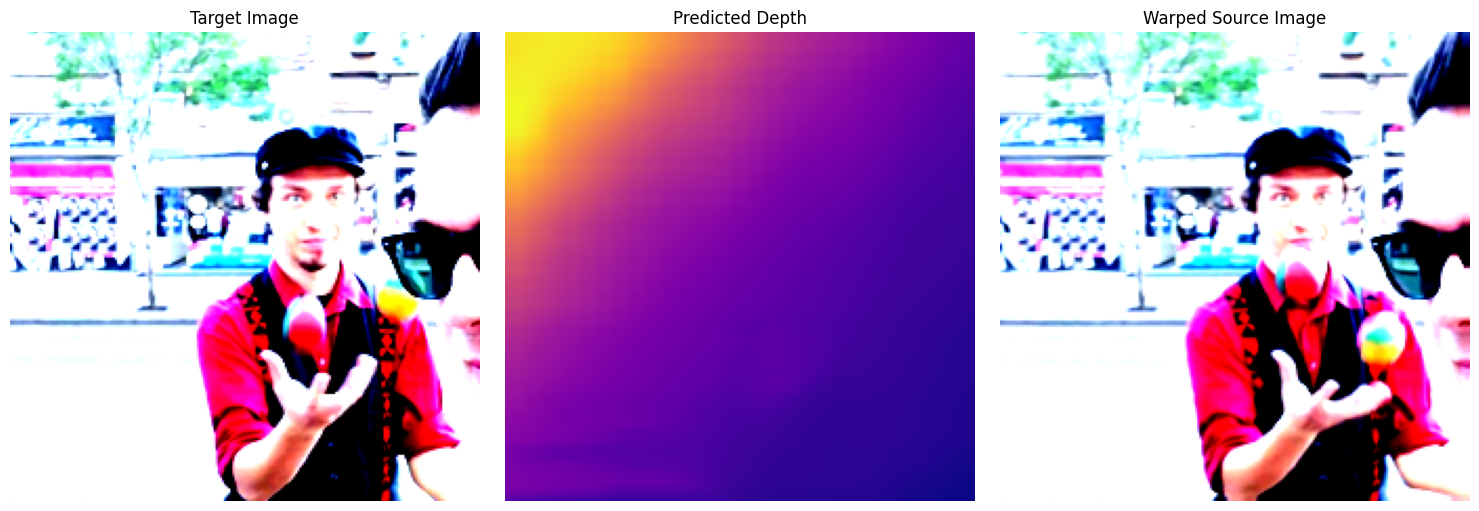

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target Image")
plt.imshow(tgt_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Depth")
plt.imshow(depth_np, cmap='plasma')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Warped Source Image")
plt.imshow(warped_np)
plt.axis('off')

plt.tight_layout()
plt.show()